In [2]:
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import os
import torch
import wandb
import random
import numpy as np

In [3]:
torch.manual_seed(2)
random.seed(2)
np.random.seed(2)

In [4]:
# CHECK DEVICE (CPU / GPU)
device = "cpu"
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Currently Using :: ", device)

Currently Using ::  cuda


In [3]:
!wandb login 57566fbb0e091de2e298a4320d872f9a2b200d12

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [5]:
def load_data(batch_size,img_size, augmentation):
    if augmentation == "Yes":
        train_augmentation = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(30),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    elif augmentation == "No":
        train_augmentation = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    test_augmentation = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])


    # Load the dataset
    data_path = "/kaggle/input/nature/inaturalist_12K"
    train_dataset = datasets.ImageFolder(os.path.join(data_path, 'train'), transform = train_augmentation)
    test_dataset = datasets.ImageFolder(os.path.join(data_path, 'val'), transform = test_augmentation)

    
    labels = train_dataset.classes
    trainset, valset = random_split(train_dataset, [8000, 1999])

    train_loader = DataLoader(trainset, batch_size = batch_size, num_workers = 2)
    val_loader = DataLoader(valset, batch_size = batch_size, num_workers = 2)
    test_loader = DataLoader(test_dataset, batch_size = batch_size, num_workers = 2)

    return labels , train_loader, val_loader, test_loader



In [6]:
from typing import Any


class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self, PARAM) -> None:
        super().__init__()
        self.flatten = nn.Flatten()
        self.filter_org = PARAM["filter_org"]
        self.filter_num = PARAM["filter_num"]
        self.activation = PARAM["activation"]
        self.con_layers = PARAM["con_layers"]
        self.den_layers = PARAM["dense_layers"]
        self.input_channel = PARAM["input_channel"]
        self.filter_num_list = self.organize_filters(self.filter_org, self.filter_num, self.con_layers)
        self.filter_size_list = PARAM["filter_size"]
        self.act = self.activation_fun(PARAM["activation"])
        self.output_act = self.activation_fun(PARAM["output_activation"])
        self.padding = PARAM["padding"]
        self.stride = PARAM["stride"]
        self.pool_padding = PARAM["pool_padding"]
        self.pool_stride = PARAM["pool_stride"]
        self.dense_output_list = PARAM["dense_output_list"]
        self.image_size = PARAM["image_size"]
        self.pool_filter_size = PARAM["pool_filter_size"]
        self.dropout_list = PARAM["dropout"]
        self.batch_norm = PARAM["batch_norm"]
        self.initialize = PARAM["init"]
        self.create_con_layers(self.input_channel, self.filter_size_list, self.dense_output_list, self.filter_num_list, self.act, self.pool_filter_size, self.output_act, self.image_size, self.dropout_list)
        

    def create_con_layers(self, input_channel, filter_size_list, dense_output_list, filter_num_list, act, pool_filter_size, output_act, image_size, dropout_list):
        self.layers = nn.ModuleList()
        computation = 0

        #canvolution layer
        for i in range(1, self.con_layers+1):
            comp = 0
            layer = nn.Sequential(nn.Conv2d(input_channel, filter_num_list[i-1], filter_size_list[i-1], padding=self.padding, stride=self.stride), act, nn.MaxPool2d(pool_filter_size, padding=self.pool_padding, stride=self.pool_stride))

            image_size = (image_size - filter_size_list[i-1] + 2 * self.padding)//self.stride + 1
            
            comp = ((filter_size_list[i-1] ** 2) * input_channel * (image_size ** 2)*filter_num_list[i-1] + filter_num_list[i-1])
            computation += comp
            image_size = (image_size + 2 * self.pool_padding-(1*(pool_filter_size-1))-1)//self.pool_stride + 1
            print(image_size)
            # print(comp)
            input_channel = filter_num_list[i-1]
            self.layers.append(layer)
        dense_input = filter_num_list[self.con_layers-1] * (image_size ** 2)
        
        #dense layer 
        for i in range(1, self.den_layers+1):
            comp = 0
            layer = nn.Sequential(nn.Linear(dense_input, dense_output_list[i-1]))

            comp = ((dense_input  + 1) * dense_output_list[i-1])
            computation += comp
            dense_input = dense_output_list[i-1]
            self.layers.append(layer)
            # print(computation)
            # print(comp)
            
        layer = nn.Sequential(nn.Linear(dense_input, 10), nn.Softmax(dim = 1)) 
        
        comp = ((dense_input  + 1) * 10)
        computation += comp
        # print(comp)
        print("Computation :: ", computation)
        self.layers.append(layer)
        
        for layer in range(self.con_layers + self.den_layers + 1):
            if self.initialize == "Xavier" and isinstance(self.layers[layer], nn.Conv2d):
                nn.init.xavier_uniform_(self.layers[layer].weight)
            if self.batch_norm == "Yes" and layer < self.con_layers:
                self.layers[layer].append(nn.BatchNorm2d(filter_num_list[layer]))
            if (layer < self.con_layers + self.den_layers) and self.dropout_list[layer] != 0:
                self.layers[layer].append(nn.Dropout(dropout_list[layer]))


    def organize_filters(self, filter_org, filter_number, layers):
        if filter_org == "same":
            filter_num = [filter_number] * layers
        elif filter_org == "double":
            filter_num = [filter_number * (2 ** i) for i in range(layers)]
        elif filter_org == "half":
            filter_num = [int(filter_number * (2 ** (-i))) for i in range(layers)]
        return filter_num
    
    
    def activation_fun(self, act):
        if act == "ReLU":
            act_fun =nn.ReLU()
        elif act == "GELU":
            act_fun = nn.GELU()
        elif act == "SiLU":
            act_fun = nn.SiLU()
        elif act == "Mish":
            act_fun = nn.Mish()
        elif act == "softmax":
            act_fun = nn.Softmax(dim=1)
        elif act == "ELU":
            act_fun = nn.ELU()
        elif act == "LeakyReLU":
            act_fun = nn.LeakyReLU()
        return act_fun
    
    
    def forward(self,x):
        for i in range(0, self.con_layers):
            x = self.layers[i](x)
        x = self.flatten(x)
        for i in range(0, self.den_layers):
            x = self.layers[i+self.con_layers](x)
        x = self.layers[self.con_layers + self.den_layers](x)
        return x   


In [144]:
PARAM = {
    "con_layers" : 5,
    "dense_layers" : 1,
    "filter_size" : [3] * 5,
    "output_activation" : "softmax", 
    "dense_output_list" : [32],
    "filter_num" : 8,
    "activation" : "ReLU",
    "filter_org" : "same", #double half
    "input_channel" : 3,
    "padding" : 0,
    "stride" : 1,
    "pool_padding" : 0,
    "pool_stride" : 1,
    "image_size" : 256,
    "pool_filter_size" : 3,
    "batch_size" : 64,
    "eta" : 0.0001,
    "dropout" : [0, 0, 0, 0, 0, 0],
    "epochs" : 10,
    "augmentation" : "No",
    "batch_norm" : "No",
    "init" : "Random"
}

net = ConvolutionalNeuralNetwork(PARAM).to(device)


252
248
244
240
236
Computation ::  165411058


In [7]:
def train_model(model, device, PARAM, log, q4 = 0):
    if log == 1:
        wandb.init(project='DL_Assignment2')
        wandb.run.name = 'SAMPLE-RUN'
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), PARAM["eta"])
    labels, train_loader, val_loader, test_loader = load_data(PARAM["batch_size"], PARAM["image_size"], PARAM["augmentation"])
    for epoch in range(PARAM["epochs"]):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        count = 0
        for images, labels in train_loader:
            # print("image is loaded")
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            # print(outputs)
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            # print(_, predicted)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            count += 1
            if count%5 == 0 :
                print(count, end = " | ")
        print("")
        model.eval()
        running_val_loss = 0.0
        correct_pred = 0
        total_pred = 0
    

        with torch.no_grad():
            for val_img, val_label in val_loader:
                val_img = val_img.to(device)
                val_label = val_label.to(device)
                val_output = model(val_img)
                loss_val = criterion(val_output, val_label)
                running_val_loss += loss_val.item()
#                 print(running_val_loss)
                idx, class_ = torch.max(val_output.data, 1)
                total_pred += val_label.size(0)
                correct_pred += (class_ == val_label).sum().item()

        
        print(f"Epoch {epoch+1}, Training Loss: {running_loss/len(train_loader)}, Training_Accuracy: {100 * correct / total}%, Validation_Loss : {running_val_loss/len(val_loader)}, Validation_accuracy : {100 * correct_pred / total_pred}%")
        if log == 1:
            wandb.log(
                {
                    'epochs' : epoch+1,
                    'training_loss' : running_loss/len(train_loader),
                    'training_accuracy' : 100 * correct / total,
                    'Validation_Loss' : running_val_loss/len(val_loader),
                    'Validation_accuracy' : 100 * correct_pred / total_pred
                }
            )
        if log == 1:
            wandb.finish()
    if q4:
        return model
    return 100 * correct_pred / total_pred
        
        

In [28]:
train_model(net, device, PARAM, 0)

5 | 10 | 15 | 20 | 25 | 30 | 35 | 40 | 45 | 50 | 55 | 60 | 65 | 70 | 75 | 80 | 85 | 90 | 95 | 100 | 105 | 110 | 115 | 120 | 125 | 
Epoch 1, Training Loss: 2.1577842559814453, Training_Accuracy: 30.075%, Validation_Loss : 2.1933319717645645, Validation_accuracy : 26.663331665832917%
5 | 10 | 15 | 20 | 25 | 30 | 35 | 40 | 45 | 50 | 55 | 60 | 65 | 70 | 75 | 80 | 85 | 90 | 95 | 100 | 105 | 110 | 115 | 120 | 125 | 
Epoch 2, Training Loss: 2.1510024909973144, Training_Accuracy: 30.9375%, Validation_Loss : 2.192193530499935, Validation_accuracy : 25.862931465732867%
5 | 10 | 15 | 20 | 25 | 30 | 35 | 40 | 45 | 50 | 55 | 60 | 65 | 70 | 75 | 80 | 85 | 90 | 95 | 100 | 105 | 110 | 115 | 120 | 125 | 
Epoch 3, Training Loss: 2.1408661365509034, Training_Accuracy: 32.175%, Validation_Loss : 2.1864872723817825, Validation_accuracy : 26.513256628314156%
5 | 10 | 15 | 20 | 25 | 30 | 35 | 40 | 45 | 50 | 55 | 60 | 65 | 70 | 75 | 80 | 85 | 90 | 95 | 100 | 105 | 110 | 115 | 120 | 125 | 
Epoch 4, Training Lo

23.36168084042021

In [23]:
wandb.finish()

## Question 2 

In [6]:
def fit_model(model, device, PARAM):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), PARAM["eta"])
    labels, train_loader, val_loader, test_loader = load_data(PARAM["batch_size"], PARAM["image_size"], PARAM["augmentation"])
    for epoch in range(PARAM["epochs"]):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        count = 0
        for images, labels in train_loader:
            # print("image is loaded")
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            # print(outputs)
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            # print(_, predicted)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            count += 1
            if count%5 == 0 :
                print(count, end = " | ")
        print("")
        model.eval()
        running_val_loss = 0.0
        correct_pred = 0
        total_pred = 0
    

        with torch.no_grad():
            for val_img, val_label in val_loader:
                val_img = val_img.to(device)
                val_label = val_label.to(device)
                val_output = model(val_img)
                loss_val = criterion(val_output, val_label)
                running_val_loss += loss_val.item()
#                 print(running_val_loss)
                idx, class_ = torch.max(val_output.data, 1)
                total_pred += val_label.size(0)
                correct_pred += (class_ == val_label).sum().item()

        
        print(f"Epoch {epoch+1}, Training Loss: {running_loss/len(train_loader)}, Training_Accuracy: {100 * correct / total}%, Validation_Loss : {running_val_loss/len(val_loader)}, Validation_accuracy : {100 * correct_pred / total_pred}%")
        wandb.log(
            {
                'epochs' : epoch+1,
                'training_loss' : running_loss/len(train_loader),
                'training_accuracy' : 100 * correct / total,
                'Validation_Loss' : running_val_loss/len(val_loader),
                'Validation_accuracy' : 100 * correct_pred / total_pred
            }
        )
    return 100 * correct_pred / total_pred
        

In [7]:
sweep_config = {
            'name': 'sweep_test ',
            'method': 'grid',
            'metric': { 'goal': 'maximize','name': 'Accuracy'},
            'parameters': 
                {
                    'epochs' : {'values': [5]},
                    'batch_size' : {'values': [64]},
                    'learning_rate' : {'values': [0.0001, 0.0005]},
                    'dense_sizes' : {'values': [16]},
                    'activation' : {'values': ['ReLU', 'GELU']},
                    'kernel' : {'values' : [8]},
                    'data_augmentation' : {'values' : ["No", "Yes"]},
                    'kernel_aug' : {'values' : ["same"]},
                    'dropout' : {'values' : [0.1]},
                    'batch_norm' : {'values' : ["No", "Yes"]},
                    'filter_size' : {'values' : [3]}
                }
            }

# sweep_config = {
#             'name': 'sweep_2 ',
#             'method': 'grid',
#             'metric': { 'goal': 'maximize','name': 'Accuracy'},
#             'parameters': 
#                 {
#                     'epochs' : {'values': [10]},
#                     'batch_size' : {'values': [32, 64]},
#                     'learning_rate' : {'values': [0.0001, 0.0005]},
#                     'dense_sizes' : {'values': [16, 32]},
#                     'activation' : {'values': ['ReLU', 'GELU', 'ELU', 'SiLU', 'Mish']},
#                     'kernel' : {'values' : [8]},
#                     'data_augmentation' : {'values' : ["Yes"]},
#                     'kernel_aug' : {'values' : ["same"]},
#                     'dropout' : {'values' : [0, 0.2]},
#                     'batch_norm' : {'values' : ["Yes"]},
#                     'filter_size' : {'values' : [3]}
#                 }
#             }


In [8]:
wandb.finish()

In [9]:
def train():
    var1 = wandb.init(project="DL_Assignment2")
    var2 = var1.config

    # wandb.run.name = 'Optimizer:- ' + var2.optimizer + ' Epoch:- ' + str(var2.epochs) + " Avtivation_Function :- " + var2.activation + " Batch_Size :- " + str(var2.batch_size) + " Initialization :- " + var2.initialization + \
    #                 ' layers:-' + str(len(var2.hidden_layers)) +' decay:-' + str(var2.weight_decay) + ' beta:-' + str(var2.beta) + ' learning_rate:-' + str(var2.learning_rate) + \
    #                 ' beta2 :- ' + str(var2.beta)
    
    wandb.run.name = (f"epochs:{var2.epochs}_lr:{var2.learning_rate}_batch_size:{var2.batch_size}_filter_size:{var2.filter_size}_act:{var2.activation}_dropout:{var2.dropout}")

    PARAM = {
        "con_layers" : 5,
        "dense_layers" : 1,
        "filter_size" :  [var2.filter_size]* 5,
        "output_activation" : "softmax", 
        "dense_output_list" : [var2.dense_sizes],
        "filter_num" : var2.kernel,
        "activation" : var2.activation,
        "filter_org" : "same", #double half
        "input_channel" : 3,
        "padding" : 0,
        "stride" : 1,
        "pool_padding" : 0,
        "pool_stride" : 1,
        "image_size" : 256,
        "pool_filter_size" : 3,
        "batch_size" : var2.batch_size,
        "eta" : var2.learning_rate,
#         "dropout" : [var2.dropout] * 6,
        "epochs" : var2.epochs,
        "augmentation" : var2.data_augmentation,
        "batch_norm" : var2.batch_norm,
        "init" : "Random"
    }

    model = ConvolutionalNeuralNetwork(PARAM).to(device)
    accuracy = fit_model(model, device, PARAM)
    wandb.log({
                "Accuracy" : accuracy
            })
    wandb.finish()


In [ ]:
sweep_id = wandb.sweep(sweep_config, project="DL_Assignment2")
wandb.agent(sweep_id, train)
wandb.finish()

In [ ]:
wandb.finish()

## Question - 4 

In [8]:
def load_test_data(img_size):
    test_augmentation = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])


    # Load the dataset
    data_path = "/kaggle/input/nature/inaturalist_12K/"
    test_dataset = datasets.ImageFolder(os.path.join(data_path, 'val'), transform = test_augmentation)
    label = test_dataset.classes
    
    selected_samples = []
    for i in range(len(label)):
        random_numbers = random.sample(range(200), 3)
        for j in range(3):
            index = 200*i + random_numbers[j]
            selected_samples.append(test_dataset.samples[index])


    # Create DataLoader for selected samples
    selected_dataset = datasets.ImageFolder(data_path, transform=test_augmentation)
    selected_dataset.samples = selected_samples
    test_loader = DataLoader(selected_dataset, batch_size=1, num_workers=2)




    return label, test_loader

    


In [9]:
PARAMS = {
    "con_layers" : 5,
    "dense_layers" : 1,
    "filter_size" : [3] * 5,
    "output_activation" : "softmax", 
    "dense_output_list" : [16],
    "filter_num" : 16,
    "activation" : "LeakyReLU",
    "filter_org" : "same", #double half
    "image_size" : 224,
    "pool_filter_size" : 3,
    "batch_size" : 8,
    "eta" : 0.0001,
    "dropout" : [0, 0, 0, 0, 0, 0.3],
    "epochs" : 5,
    "augmentation" : "No",
    "batch_norm" : "No",
    "init" : "Random",
    "input_channel" : 3,
    "padding" : 0,
    "stride" : 1,
    "pool_padding" : 0,
    "pool_stride" : 1,
}

MODEL1 = ConvolutionalNeuralNetwork(PARAMS).to(device)

220
216
212
208
204
Computation ::  446332874


In [10]:
mt = train_model(MODEL1, device, PARAMS, 0, 1) #train_model(net, device, PARAM, 0)
print(mt)

5 | 10 | 15 | 20 | 25 | 30 | 35 | 40 | 45 | 50 | 55 | 60 | 65 | 70 | 75 | 80 | 85 | 90 | 95 | 100 | 105 | 110 | 115 | 120 | 125 | 130 | 135 | 140 | 145 | 150 | 155 | 160 | 165 | 170 | 175 | 180 | 185 | 190 | 195 | 200 | 205 | 210 | 215 | 220 | 225 | 230 | 235 | 240 | 245 | 250 | 255 | 260 | 265 | 270 | 275 | 280 | 285 | 290 | 295 | 300 | 305 | 310 | 315 | 320 | 325 | 330 | 335 | 340 | 345 | 350 | 355 | 360 | 365 | 370 | 375 | 380 | 385 | 390 | 395 | 400 | 405 | 410 | 415 | 420 | 425 | 430 | 435 | 440 | 445 | 450 | 455 | 460 | 465 | 470 | 475 | 480 | 485 | 490 | 495 | 500 | 505 | 510 | 515 | 520 | 525 | 530 | 535 | 540 | 545 | 550 | 555 | 560 | 565 | 570 | 575 | 580 | 585 | 590 | 595 | 600 | 605 | 610 | 615 | 620 | 625 | 630 | 635 | 640 | 645 | 650 | 655 | 660 | 665 | 670 | 675 | 680 | 685 | 690 | 695 | 700 | 705 | 710 | 715 | 720 | 725 | 730 | 735 | 740 | 745 | 750 | 755 | 760 | 765 | 770 | 775 | 780 | 785 | 790 | 795 | 800 | 805 | 810 | 815 | 820 | 825 | 830 | 835 | 840 | 845 | 850 | 

In [11]:
import matplotlib.pyplot as plt

In [12]:
def get_prediction(model, img, correct):
    img = img.to(device)
    model.eval()
    with torch.no_grad():
#         print("image :: ", img)
        pred = model(img)
#         print(pred, correct)
        prob, class_ = torch.max(pred.data, 1)
    return prob, class_

In [13]:


def predicttt(model, test_loader, label):
    total = 0
    count = 0
    for image, lbl in test_loader:
        image = image.to(device)
        lbl = lbl.to(device)
        prob, pred = get_prediction(model, image, lbl)
        print(label[lbl], label[pred])
        if pred == lbl:
            count += 1
        total += 1
    print(f"{count}/{total}")
        
def plot_grid(model):
    label, test_loader = load_test_data(224)
    total = 0
    fig, axes = plt.subplots(10, 3, figsize=(10, 30))
    count = 0
    for image, lbl in test_loader:
        image = image.to(device)
        lbl = lbl.to(device)
        row = count // 3  # Calculating row index for subplot
        col = count % 3   # Calculating column index for subplot
        prob, pred = get_prediction(model, image, lbl)
#         print(prob, pred)
        image = image.cpu().squeeze().permute(1, 2, 0)
        
        axes[row, col].imshow(image)  # Displaying grayscale image
        axes[row, col].set_title(label[lbl], fontsize=14, fontweight='bold', color='blue', family='serif', loc='center', pad=8)  # Setting title with class label
        axes[row, col].axis('off')  # Turning off axis
        if pred == lbl:
            total += 1
            axes[row, col].text(0.5, -0.08, label[pred], fontweight='bold', horizontalalignment='center', verticalalignment='center', fontsize=14, color='green', family = 'serif', transform=axes[row, col].transAxes)
        else:
            axes[row, col].text(0.5, -0.08, label[pred], fontweight='bold', horizontalalignment='center', verticalalignment='center', fontsize=14, color='red', family = 'serif', transform=axes[row, col].transAxes)
        # pred_class = get_prediction()
        count += 1
    plt.subplots_adjust(hspace=0.4)
    # plt.subplots_adjust(wspace=1)
    plt.tight_layout()

# Displaying the plot
    plt.show()
    return total




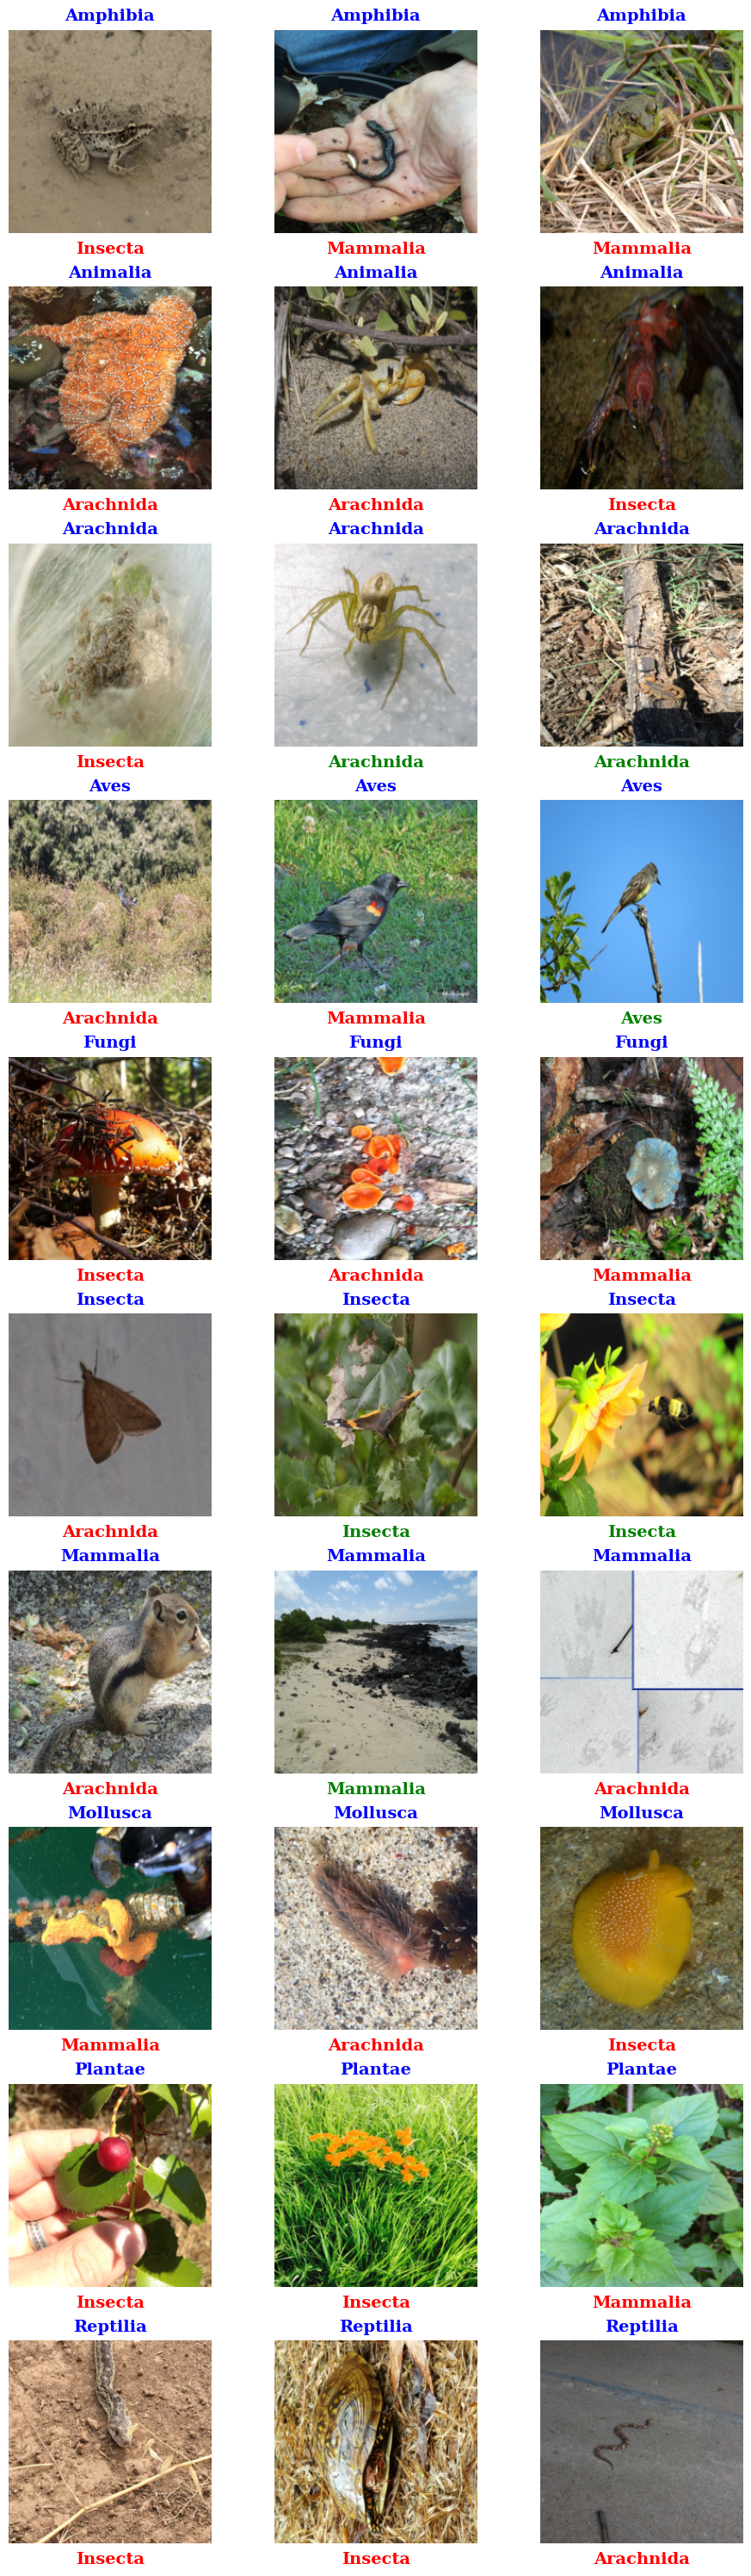

6

In [18]:
plot_grid(mt)